# JetRail 通勤人数时序预测
## 1. 系统准备和数据加载
Versions:

- Python = 3.7

- Pandas = 0.20.3

- sklearn = 0.19.1

导入依赖包

In [1]:
import pandas as pd
import numpy as np                 # 数学计算
import matplotlib.pyplot as plt    # 画图
from datetime import datetime      # 访问时间
from pandas import Series          # 可以使用序列
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')  # 忽略 warning

读取训练和测试数据集

In [2]:
train = pd.read_csv('D:\data\JetRail\Train_SU63ISt.csv')
test = pd.read_csv('D:\data\JetRail\Test_0qrQsBZ.csv')

我们将原始数据拷贝一份，这样即使我们对数据集进行一些修改，也不会影响原始数据集

In [3]:
train_orig = train.copy()
test_orig = test.copy()

## 2. 数据概览

我们首先可以对数据做一些假设：
* 随着年份增加乘客数量是增加的
> 猜想：因为人口数量是增加的
* 一年内乘客数量在5月到10月之间是最多的
> 猜想：因为这期间会有很多旅游的人
* 工作人的乘客数量多余周末
> 猜想：工作日人们都需要上班或上学
* 乘客数在每天的高峰时间段会更多
> 猜想：高峰期是出行时间段

### 2.1 数据结构

快速预览一下我们的数据的结构

In [4]:
train.columns, test.columns

(Index(['ID', 'Datetime', 'Count'], dtype='object'),
 Index(['ID', 'Datetime'], dtype='object'))

我们可以看到在训练数据集里面数据由'ID'，'Datetime'，'Count'，但是测试数据集只有'ID'，'Datetime'。因此我们需要通过预测的方式获取测试数据中的'Count'

- ID 数据行的唯一标识
- Datetime 数据观测的时间
- Count 使用JatRail出行的用户数量

In [5]:
train.dtypes, test.dtypes

(ID           int64
 Datetime    object
 Count        int64
 dtype: object, ID           int64
 Datetime    object
 dtype: object)

可以看到'ID'和'Count'是`int64`类型的，而'Datetime'是`object`类型的

我们还可以查看数据集的shape

In [6]:
train.shape, test.shape

((18288, 3), (5112, 2))

我们可以看到训练数据集有18288条记录，测试集有5112条记录

### 2.2 特征提取

首先我们需要将'Datetime'转换为python中的`Datetime`结构，这样方便我们之后根据时间的年月日或者时分秒来分析

In [7]:
train['Datetime'] = pd.to_datetime(train.Datetime, format='%d-%m-%Y %H:%M')
test['Datetime'] = pd.to_datetime(test.Datetime, format='%d-%m-%Y %H:%M')
train_orig['Datetime'] = pd.to_datetime(train_orig.Datetime, format='%d-%m-%Y %H:%M')
test_orig['Datetime'] = pd.to_datetime(test_orig.Datetime, format='%d-%m-%Y %H:%M')

In [8]:
train.columns, test.columns, train_orig.columns, test_orig.columns

(Index(['ID', 'Datetime', 'Count'], dtype='object'),
 Index(['ID', 'Datetime'], dtype='object'),
 Index(['ID', 'Datetime', 'Count'], dtype='object'),
 Index(['ID', 'Datetime'], dtype='object'))

In [9]:
train.dtypes, test.dtypes, train_orig.dtypes, test_orig.dtypes

(ID                   int64
 Datetime    datetime64[ns]
 Count                int64
 dtype: object, ID                   int64
 Datetime    datetime64[ns]
 dtype: object, ID                   int64
 Datetime    datetime64[ns]
 Count                int64
 dtype: object, ID                   int64
 Datetime    datetime64[ns]
 dtype: object)

我们可以看到训练和测试集的'Datetime'列已经转化成类型`Datetime`

由于我们假设了hour，day，month，year对JetRail项目的乘客数的影响，因此我们需要从数据集中提取这部分数据，将它们作为单独的列

In [10]:
for i in (train, test, train_orig, test_orig):
    i['year'] = i.Datetime.dt.year
    i['month'] = i.Datetime.dt.month
    i['day'] = i.Datetime.dt.day
    i['hour'] = i.Datetime.dt.hour

In [11]:
train.columns, test.columns

(Index(['ID', 'Datetime', 'Count', 'year', 'month', 'day', 'hour'], dtype='object'),
 Index(['ID', 'Datetime', 'year', 'month', 'day', 'hour'], dtype='object'))

我们可以看到数据集中的每行数据都多了新的'year'，'month'，'day'，'hour'属性

由于我们也假设了乘客数量也可能和今天是工作日还是周末有关，因此我们也需要提取这一个属性，此处仅为演示只提取训练数据集

In [12]:
temp = train.Datetime.dt.dayofweek # 获取train.Datetime整个属性的dayofweek属性，返回一个series赋值给新的列'day_of_week'
train['day_of_week'] = temp

让我们设置`1`代表本日为周末，`0`代表本日为工作日

In [13]:
def applyer(row):
    if row.dayofweek == 5 or row.dayofweek == 6:
        return 1
    else:
        return 0
temp2 = train['Datetime'].apply(applyer) # 训练集的Datetime形成一个单列series，整个series的每一行值都执行applyer这个函数
train['weekend'] = temp2

我们来查看一下JetRail的时间序列图

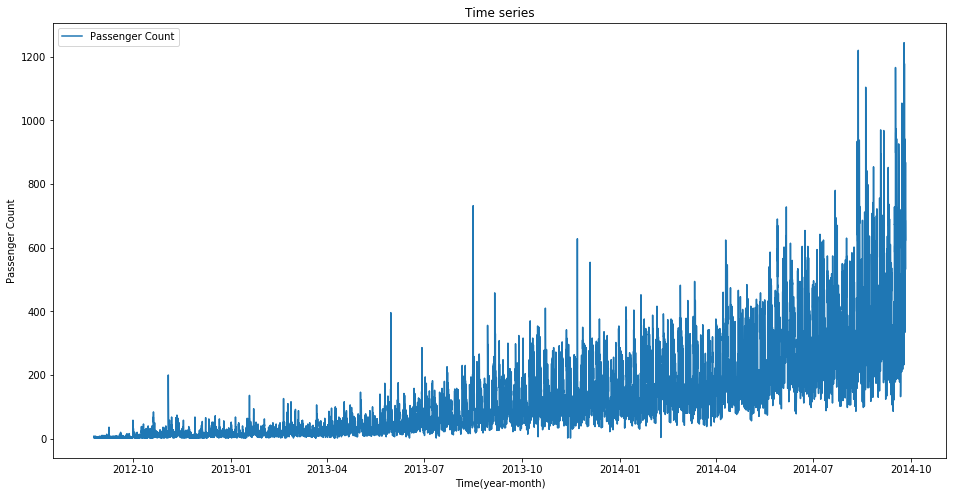

In [14]:
train.index = train['Datetime'] # 修改DateFrame的索引，变成以'Datetime'作为数据索引，以便将其作为时序图的X轴
df = train.drop('ID', 1) # 去掉ID列，1代表axis=1，轴为1
ts = df['Count'] # 此时ts为'Count'的series，但是它的index索引为'Datetime'
plt.figure(figsize=(16,8))
plt.plot(ts, label='Passenger Count')
plt.title('Time series')
plt.xlabel('Time(year-month)')
plt.ylabel('Passenger Count')
plt.legend(loc='best') # 图例的位置设置为'best'，自动寻找最佳位置

我们可以从上图中发现，乘客数量是是随时间呈现上升趋势的，并且在某些特地的日期会有突然的增加，我们可以说可能在某一天由于某些事件交通突然变的繁忙

### 2.3 探索性分析

根据我们在 [数据概览](#2.-数据概览)中的假设，我们依次来验证一下

首先验证一下乘客数量是按照年份增长而增长的，我们可以通过画柱状图来实现

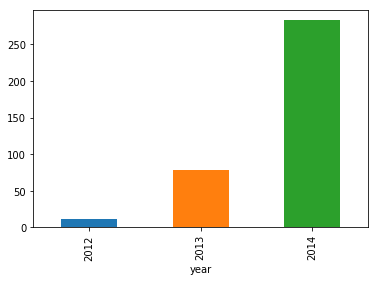

In [15]:
train.groupby('year')['Count'].mean().plot.bar()

然后我们来验证一下乘客数量是不是在一年内的5-10月份最多

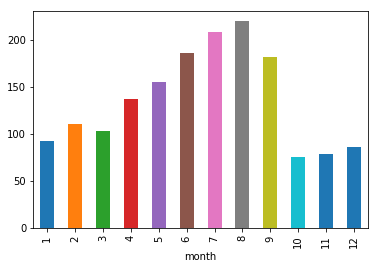

In [16]:
train.groupby('month')['Count'].mean().plot.bar() # 根据月份做进行分类，新的series的索引列为month，将所有年份的1-12都划分在一起，然后做平均值

我们看到后三个月乘客数量的平均值有明显的下降，为了更好地分析乘客数量与月份的关系，我们需要分开观察每一年每个月的乘客数量的变化

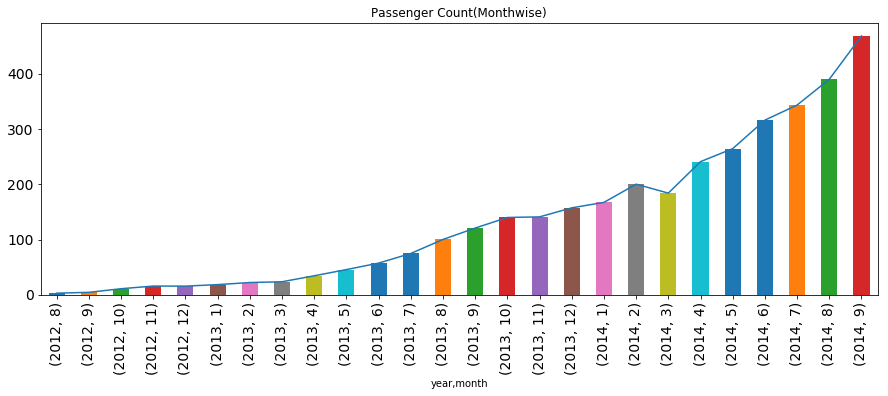

In [17]:
temp = train.groupby(['year', 'month'])['Count'].mean() # 会对每一年每个月的乘客数量作平均
temp.plot(kind='line', figsize=(15,5), title= 'Passenger Count(Monthwise)', fontsize=14)
temp.plot(kind='bar', figsize=(15,5), title= 'Passenger Count(Monthwise)', fontsize=14)

我们可以看到2014年10-12月的数据是不存在的，因此解释了之前柱状图后三个月数据突降，同时可以看出乘客数量是随月份增加呈现出指数增长的态势的

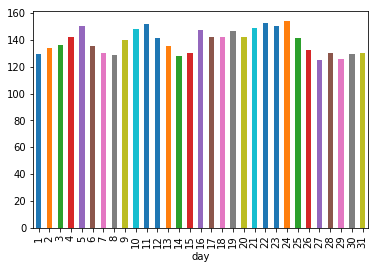

In [18]:
train.groupby('day')['Count'].mean().plot.bar()

根据day来划分我们看不出什么特殊的信息

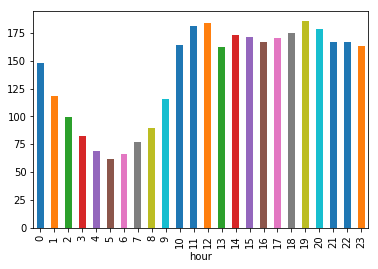

In [19]:
train.groupby('hour')['Count'].mean().plot.bar()

根据时间柱状图，我们发现PM 7是高峰，PM7之后呈现出下降趋势直到第二天凌晨5

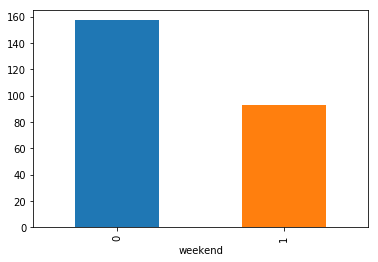

In [20]:
train.groupby('weekend')['Count'].mean().plot.bar()

根据是否是工作日来分析，我们发现周末的乘客数小于工作日的乘客数

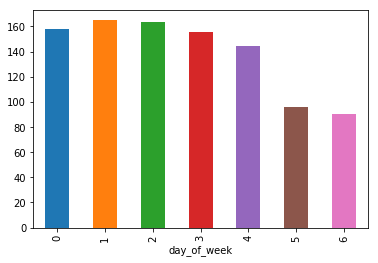

In [21]:
train.groupby('day_of_week')['Count'].mean().plot.bar()

根据day_of_week来分析发现周六、周日的数据较一星期中其它时间较少

我们先来体验一下基本的建模方式，由于'ID'数据对建模是没有用的，因此我们将它去掉

In [22]:
train = train.drop('ID', 1)

由于以Hour为单位的数据存在很多噪声，因此我们需要将Hour为单位的数据聚合转化为daily, weekly, monthly的时序数据

In [23]:
train.Timestamp = pd.to_datetime(train.Datetime, format='%d-%m-%Y %H:%M')
train.index = train.Timestamp # 将train的索引更改为时间

# Hourly time series
hourly = train.resample('H').mean() # 根据索引来重新抽取样本间隔(频率)

# _3hourly = train.resample('3H').mean() # 每三小时一个样本

# Daily time series
daily = train.resample('D').mean()

# weekly time series
weekly = train.resample('W').mean()

# monthly time series
monthly = train.resample('M').mean()

我们来查看一下不同频率下的时间序列的折线图

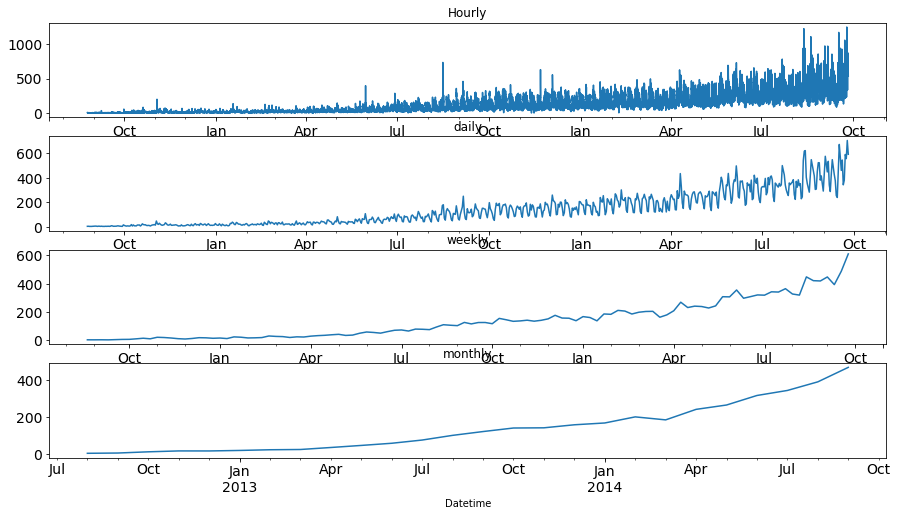

In [24]:
fig, axs = plt.subplots(4, 1)

hourly.Count.plot(figsize=(15,8), title='Hourly', fontsize=14, ax=axs[0])
daily.Count.plot(figsize=(15,8), title='daily', fontsize=14, ax=axs[1])
weekly.Count.plot(figsize=(15,8), title='weekly', fontsize=14, ax=axs[2])
monthly.Count.plot(figsize=(15,8), title='monthly', fontsize=14, ax=axs[3])

我们可以发现序列的时间间隔越长，乘客数量也就越稳定

In [25]:
test.Timestamp = pd.to_datetime(test.Datetime, format='%d-%m-%Y %H:%M')
test.index = test.Timestamp

# Converting test to daily
test = test.resample('D').mean()

# Converting train to daily
train = train.resample('D').mean()


## 3. 数据模型

### 3.1 将数据分为训练与验证部分

我们选取后三个月的数据作为验证集合，我们在划分训练和验证数据集的时候，**不能进行随机的划分**，因为它们是时序数据，如果这样随机划分，那么训练数据集中可能会存在未来数据，验证集中会存在历史数据，那么这就相当于我们用未来的数据去预测过去的数据，这在真实场景中是不存在的。

In [26]:
# 训练集数据从而2012-08-25开始2014-09-25结束
Train = train.ix['2012-08-25':'2014-06-24'] # 训练数据
Vaild = train.ix['2014-06-25':'2014-09-25'] # 验证数据

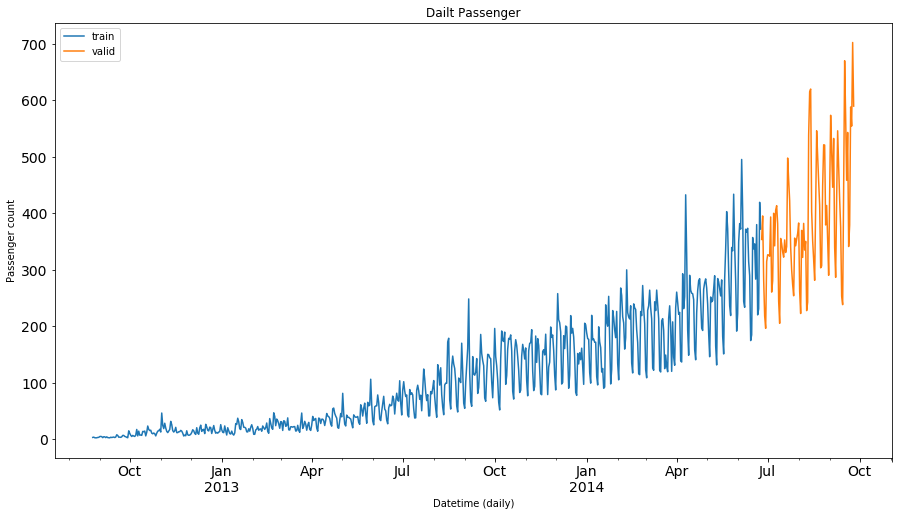

In [27]:
Train.Count.plot(figsize=(15,8), title='Daily Passenger', fontsize=14, label='train')
Vaild.Count.plot(figsize=(15,8), title='Dailt Passenger', fontsize=14, label='valid')
plt.xlabel('Datetime (daily)')
plt.ylabel('Passenger count')
plt.legend(loc='best')
plt.show()

在以上图中，蓝色部分是我们划分的训练数据集，橙色部分是我们的验证数据集，我们之后将用不同的预测模型来预测橙色部分的数据，并可视化我们的预测准确度

### 3.2 建模方法
以下我们将使用不同的时序预测模型来预测我们的值：
* Navie Approach
* Moving Average 移动平均
* Simple Exponential Smoothing 简单指数平滑
* Holt's Linear Trend Model 霍尔特线性趋势模型

#### 3.2.1 Navie Approach
最天真的预测方法是，我们将最后一个观测点的数据作为我们的预测数据，我们假设观测数据为：

|Day|Passenger count|
|---|---------------|
|1  |     6     |
|2  |     9     |
|3  |     7     |
|4  |     4     |
|5  |     5     |

可知最后一个观测值为5，那么按照navie方法，则预测6，7两天的Passenger count为5：

|Day|Passenger count|
|---|---------------|
|1  |     6     |
|2  |     9     |
|3  |     7     |
|4  |     4     |
|5  |     5     |
|**6**  |     **5**     |
|**7**  |     **5**     |

我们使用相同的方法来对我们的数据集进行预测

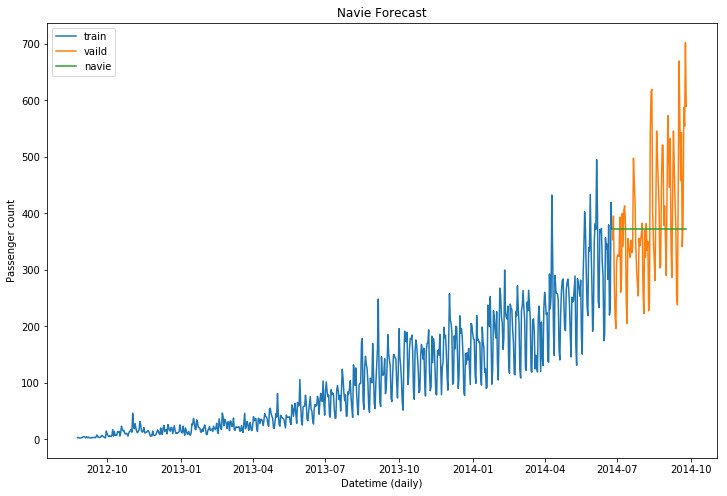

In [29]:
dd = np.asarray(Train.Count)
y_hat = Vaild.copy()
y_hat['Navie'] = dd[len(dd) - 1]
plt.figure(figsize=(12,8))
plt.plot(Train.index, Train['Count'], label='train')
plt.plot(Vaild.index, Vaild['Count'], label='vaild')
plt.plot(y_hat.index, y_hat['Navie'], label='navie')
plt.legend(loc='best')
plt.title('Navie Forecast')
plt.xlabel('Datetime (daily)')
plt.ylabel('Passenger count')
plt.show()

为了检查预测的准确度，我们计算均方根误差（Root Mean Square Error, rmse），它是残差的标准差，参数是用来衡量回归线数据点距离的，rmse的公式为：

$$
rmse = sqrt\sum_{i=1}^{N}\frac{1}{N}(p-a)^2
$$

现在我们来计算下navie方法的rmse

In [32]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rms = sqrt(mean_squared_error(Vaild.Count, y_hat.Navie))
print(rms)

111.79050467496724


#### 3.2.2 Moving Average
将后几日的平均值作为未来的预测值

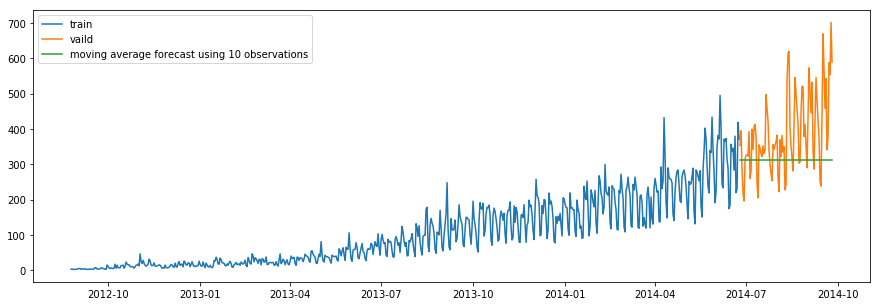

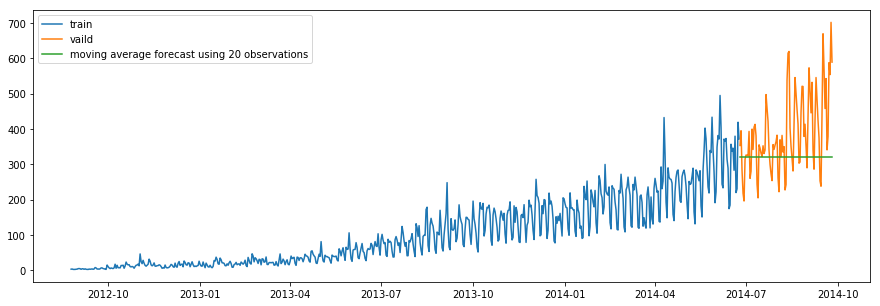

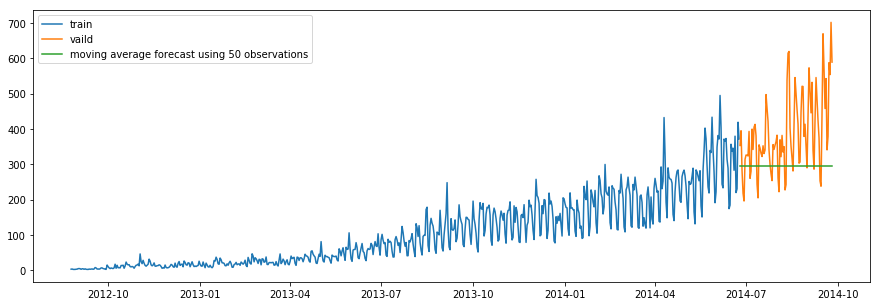

In [36]:
y_hat_avg = Vaild.copy()
y_hat_avg['moving_avg_forecast_10'] = Train.Count.rolling(10).mean().iloc[-1] # 最后10天的平均值
plt.figure(figsize=(15, 5))
plt.plot(Train.Count, label='train')
plt.plot(Vaild.Count, label='vaild')
plt.plot(y_hat_avg['moving_avg_forecast_10'], label='moving average forecast using 10 observations')
plt.legend(loc='best')
plt.show()

y_hat_avg['moving_avg_forecast_20'] = Train.Count.rolling(20).mean().iloc[-1] # 最后10天的平均值
plt.figure(figsize=(15, 5))
plt.plot(Train.Count, label='train')
plt.plot(Vaild.Count, label='vaild')
plt.plot(y_hat_avg['moving_avg_forecast_20'], label='moving average forecast using 20 observations')
plt.legend(loc='best')
plt.show()

y_hat_avg['moving_avg_forecast_50'] = Train.Count.rolling(50).mean().iloc[-1] # 最后10天的平均值
plt.figure(figsize=(15, 5))
plt.plot(Train.Count, label='train')
plt.plot(Vaild.Count, label='vaild')
plt.plot(y_hat_avg['moving_avg_forecast_50'], label='moving average forecast using 50 observations')
plt.legend(loc='best')
plt.show()

In [38]:
rmse_10 = sqrt(mean_squared_error(Vaild.Count, y_hat_avg['moving_avg_forecast_10']))
rmse_20 = sqrt(mean_squared_error(Vaild.Count, y_hat_avg['moving_avg_forecast_20']))
rmse_50 = sqrt(mean_squared_error(Vaild.Count, y_hat_avg['moving_avg_forecast_50']))
print("rmse(10): %f\nrmse(20): %f\nrmse(50): %f" % (rmse_10, rmse_20, rmse_50))

rmse(10): 134.237333
rmse(20): 130.449850
rmse(50): 144.191757


#### 3.2.3 Simple Exponential Smoothing
- 最新观测值的权重要大于老的观测值
- 权重随时间倒退而呈现出指数下降的趋势

为此，我们需要再安装一个统计学包`pip install statsmodels` 如果导入包时报错`ModuleNotFoundError: No module named 'patsy'` 则执行
`pip install pasty`

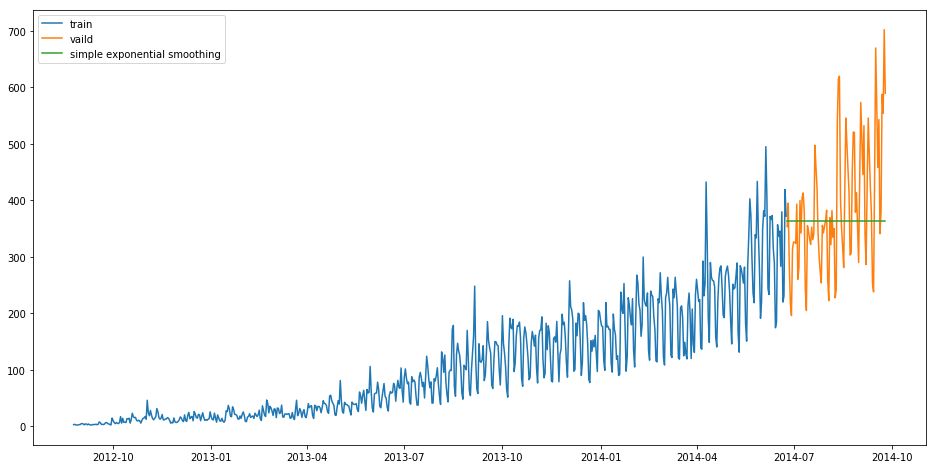

In [51]:
from statsmodels.tsa.api import SimpleExpSmoothing
y_hat_ses = Vaild.copy()
fit1 = SimpleExpSmoothing(np.asarray(Train.Count)).fit(smoothing_level=0.6, optimized=False)
y_hat_ses['ses'] = fit1.forecast(len(Vaild))
plt.figure(figsize=(16, 8))
plt.plot(Train.Count, label='train')
plt.plot(Vaild.Count, label='vaild')
plt.plot(y_hat_ses['ses'], label='simple exponential smoothing')
plt.legend(loc='best')
plt.show()

In [47]:
rmse = sqrt(mean_squared_error(Vaild.Count, y_hat_ses['ses']))
print(rmse)

113.43708111884514


#### 3.2.4 Holt’s Linear Trend Model
- 它是对简单的指数平滑的扩展
- 它考虑了数据的趋势性

首先，我们可以将原始的时间序列数据分为4个部分：
- 观测值
- 趋势， 展示了数据是上升趋势还是下降趋势
- 周期性，提取数据中周期变化的因素
- 残差，即从观测值中去除趋势、周期性后剩余的值

我们可以通过可视化的办法分析一下这四部分

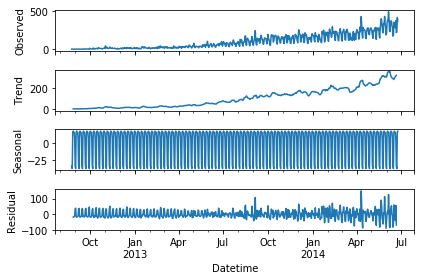

In [50]:
import statsmodels.api as sm
sm.tsa.seasonal_decompose(Train.Count).plot()
result = sm.tsa.stattools.adfuller(train.Count)
plt.show()

我们可以看到数据的趋势是上升趋势的，因此我们依据这一趋势来进行建模

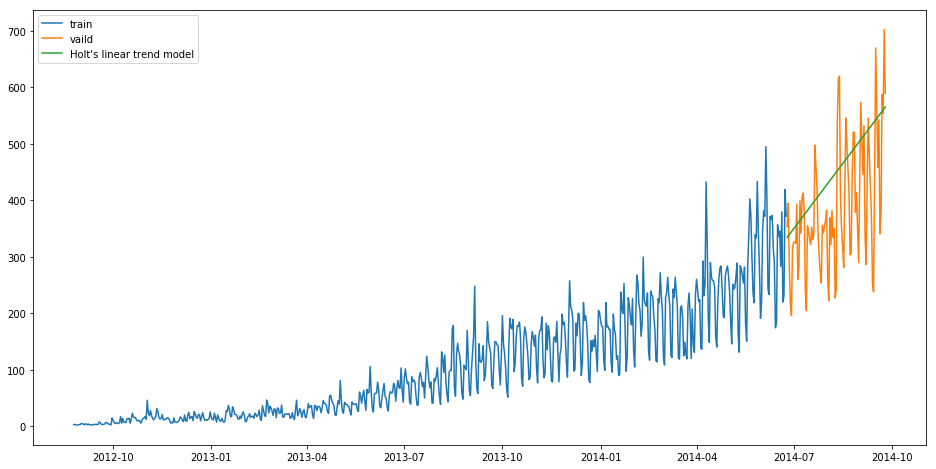

In [52]:
from statsmodels.tsa.api import Holt

y_hat_holt = Vaild.copy()
fit2 = Holt(np.asarray(Train.Count)).fit(smoothing_level=0.3, smoothing_slope=0.1)
y_hat_holt['holt'] = fit2.forecast(len(Vaild))
plt.figure(figsize=(16, 8))
plt.plot(Train.Count, label='train')
plt.plot(Vaild.Count, label='vaild')
plt.plot(y_hat_holt['holt'], label="Holt's linear trend model" )
plt.legend(loc='best')
plt.show()

In [53]:
rmse = sqrt(mean_squared_error(Vaild.Count, y_hat_holt['holt']))
print(rmse)

112.94278345314041


### 3.3 提交预测结果

我们使用基于daily的时间序列数据训练出的`Holt's Linear Trend`模型来预测未来每一小时的值

In [70]:
submission = pd.read_csv('D:\data\JetRail\submission.csv')
predict = fit2.forecast(len(test))
test['prediction'] = predict

# 计算每一小时的Passenger count占全部的比率
train_orig['radio'] = train_orig['Count'] / train_orig['Count'].sum()

# groupby hourly
temp = train_orig.groupby(['hour'])['radio'].sum()

# groupby to csv
pd.DataFrame(temp, columns=['hour', 'radio']).to_csv('GROUPby.csv')

temp2 = pd.read_csv('GROUPby.csv')
# hour.1 is NaN column
temp2.drop('hour.1', 1)

# Merget test and test_orig on year month day
merge = pd.merge(test, test_orig, on=('day', 'month', 'year'), how='left')
merge['hour'] = merge['hour_y'] # hour_y 是因为test和test_orign的hour项不一致
merge = merge.drop(['year', 'month', 'day', 'hour_x', 'hour_y'], axis=1)

predict = pd.merge(merge, temp2, on='hour', how='left')
# 将预测值乘上scaling_factor 
# predict['prediction'] * 24 表示一天内总的passenger count 
# predict['radio']  表示每一小时占全天的passenger count的比例
predict['Count'] = predict['prediction'] * 24 * predict['radio'] 
predict['ID'] = predict['ID_y']

submission = predict.drop(['ID_x', 'ID_y', 'prediction', 'hour', 'radio', 'hour.1', 'Datetime'], axis=1)

# Converting the final submission to csv
pd.DataFrame(submission, columns=['ID', 'Count']).to_csv('D:\data\JetRail\holt_linear.csv')

### 3.4 使用 Holt Winter's Model
我们之前提到的4种模型都没有考虑时序数据的周期性影响，Holt Winter's Model就是一种在水平和趋势的基础上，对周期性成分也应用了指数平滑

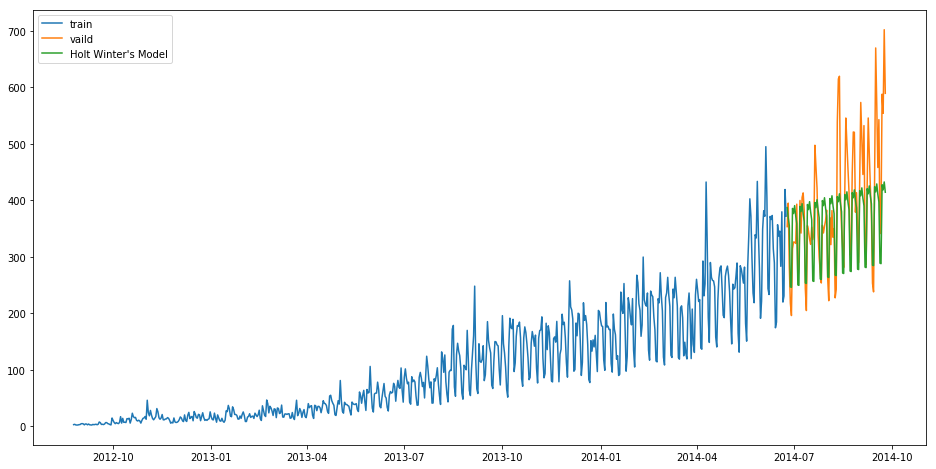

In [72]:
from statsmodels.tsa.api import ExponentialSmoothing
y_hat_holtw = Vaild.copy()
fit3 = ExponentialSmoothing(np.asarray(Train['Count']), seasonal_periods=7, trend='add', seasonal='add').fit()
y_hat_holtw['holt_winter'] = fit3.forecast(len(Vaild))
plt.figure(figsize=(16,8))
plt.plot(Train.Count, label='train')
plt.plot(Vaild.Count, label='vaild')
plt.plot(y_hat_holtw['holt_winter'], label="Holt Winter's Model")
plt.legend(loc='best')
plt.show()

我们重新计算一下它的均方根误差rmse

In [74]:
rmse = sqrt(mean_squared_error(Vaild.Count, y_hat_holtw['holt_winter']))
print(rmse)

82.37900996094073


我们可以看到**在当前验证集下**误差有明显的下降，但是当结果被在线提交后，rank分数如何就不一定了，这个方法可以更好地预测周期性，但是在趋势预测上可能就不那么准确了。

In [82]:
predict = fit3.forecast(len(test))
test['prediction'] = predict

merge = pd.merge(test, test_orig, on=('day', 'month', 'year'), how='left')
merge['hour'] = merge['hour_y']
merge = merge.drop(['year', 'month', 'Datetime', 'hour_x', 'hour_y'], axis=1)

prediction = pd.merge(merge, temp2, on='hour', how='left')
prediction['Count'] = prediction['prediction'] * prediction['radio'] * 24
prediction['ID'] = prediction['ID_y']
submission = prediction.drop(['ID_x', 'ID_y', 'hour', 'hour.1', 'day', 'prediction', 'radio'], axis=1)

pd.DataFrame(submission, columns=['ID', 'Count']).to_csv('D:\data\JetRail\holt_winter.csv')

## 4.  使用ARIMA模型

### 4.1 稳定性检验
使用 Dickey Fuller 测试（统计学中的“迪基-福勒”检验）可以测试一个自回归模型是否存在单位根（unit root）在计量经济学的自回归模型里，如果在
$y_{t}=a+by_{t-1}+\varepsilon _{t}$里，系数 $|b|=1$，那么一个单位根是存在的。